<a href="https://colab.research.google.com/github/Thujaina/NIT-Internship/blob/main/weighted%20categorical%20ce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install imblearn

In [2]:
!pip install seaborn

In [3]:
!pip install -U tensorflow scikeras imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.14.0
    Uninstalling imbalanced-learn-0.14.0:
      Successfully uninstalled imbalanced-learn-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.1

In [4]:
!pip install scikeras

In [5]:
!pip install -U scikit-learn scikeras tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 113.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [6]:
from scikeras.wrappers import KerasClassifier

In [7]:
from sklearn.model_selection import KFold, cross_val_score


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import backend as K

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef
)

from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier
import tensorflow as tf


import warnings
warnings.filterwarnings("ignore")


In [9]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [10]:
!ls /content/drive/MyDrive/datasets/ECG/

mitbih_test.csv  mitbih_test.gsheet  mitbih_train.csv


In [11]:
TRAIN_PATH = "/content/drive/MyDrive/datasets/ECG/mitbih_train.csv"
TEST_PATH  = "/content/drive/MyDrive/datasets/ECG/mitbih_test.csv"

train = pd.read_csv(TRAIN_PATH,header=None)
test  = pd.read_csv(TEST_PATH,header=None)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (87554, 188)
Test shape: (21892, 188)


In [12]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]


In [13]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [14]:
y_res_cat = to_categorical(y_res, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)


In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res_cat, test_size=0.2, random_state=0
)


In [16]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_res),
    y=y_res
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0)}


In [24]:
class_weights_list = [class_weights[i] for i in range(5)]


In [28]:
def weighted_categorical_crossentropy(class_weights):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return -tf.reduce_sum(
            y_true * tf.math.log(y_pred) * class_weights,
            axis=-1
        )

    return loss


In [34]:
def ann_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    loss_fn = weighted_categorical_crossentropy(class_weights_list)

    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy']
    )

    return model   # ← THIS LINE WAS MISSING / MISPLACED


In [35]:
model = ann_model()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)



Epoch 1/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8403 - loss: 0.4424 - val_accuracy: 0.9400 - val_loss: 0.1633
Epoch 2/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9513 - loss: 0.1393 - val_accuracy: 0.9641 - val_loss: 0.0990
Epoch 3/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9674 - loss: 0.0938 - val_accuracy: 0.9687 - val_loss: 0.0885
Epoch 4/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9748 - loss: 0.0741 - val_accuracy: 0.9748 - val_loss: 0.0751
Epoch 5/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9793 - loss: 0.0615 - val_accuracy: 0.9811 - val_loss: 0.0560
Epoch 6/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9825 - loss: 0.0533 - val_accuracy: 0.9838 - val_loss: 0.0509
Epoch 7/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9847 - loss: 0.0461 - val_accuracy: 0.9831 - val_loss: 0.0508
Epoch 8/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9867 - loss: 0

In [36]:
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)

mcc = matthews_corrcoef(y_val_true, y_val_pred)
print("Validation MCC:", mcc)


2265/2265 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Validation MCC: 0.9836490755286816


In [37]:
test_predictions = model.predict(X_test)
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9617 - loss: 0.1195
Test Accuracy: 0.9577928185462952
Test Loss: 0.16473709046840668


In [38]:
print(classification_report(
    np.argmax(y_test_cat, axis=1),
    np.argmax(test_predictions, axis=1)
))


              precision    recall  f1-score   support

           0       0.99      0.96      0.98     18118
           1       0.48      0.81      0.60       556
           2       0.89      0.94      0.91      1448
           3       0.71      0.83      0.77       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.81      0.91      0.85     21892
weighted avg       0.97      0.96      0.96     21892



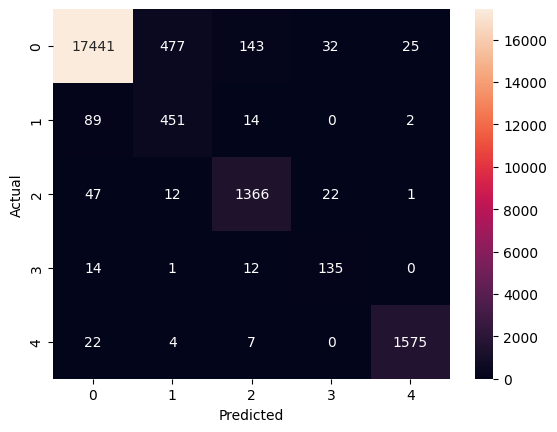

In [39]:
cm = confusion_matrix(
    np.argmax(y_test_cat, axis=1),
    np.argmax(test_predictions, axis=1)
)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [40]:
estimator = KerasClassifier(
    model=ann_model,
    epochs=10,
    batch_size=64,
    verbose=0
)

kfold = KFold(n_splits=4, shuffle=True, random_state=42)

results = cross_val_score(
    estimator,
    X_res,
    y_res_cat,
    cv=kfold,
    scoring="accuracy"
)

print("Cross-validation scores:", results)
print("Mean CV accuracy:", results.mean())


Cross-validation scores: [0.98529623 0.98484363 0.97882745 0.98455645]
Mean CV accuracy: 0.9833809418264177
